In [1]:
from pynq import GPIO

from time import sleep
from doa_mts import *
o1 = doaMtsOverlay('doa_mts.bit')

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants

fc = 5.7e9
min_ang = -90 # min scanning angle
max_ang = 90 # max scanning angle
scan_res = 1 # scan resolution
scan_axis = list(np.arange(min_ang, max_ang+1, scan_res)) # angles axis
num_elements = 4
# c = 299792458
lbd = scipy.constants.c / fc
d = lbd/2


channels = 8 # 4 I + 4 Q
N = len(o1.adc_capture) // channels

In [52]:
AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
o1.internal_capture(AlignedCaptureSamples)

iq_prod = np.zeros((1,len(o1.adc_prod)),dtype=np.int32)
o1.prod_capture(iq_prod)

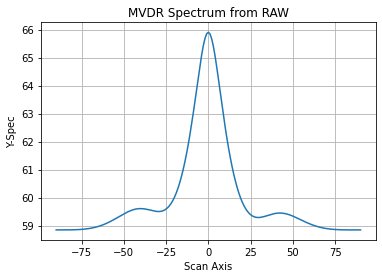

0
0.0791327953338623 sec Elapsed


In [53]:
# Data acq from FPGA
# AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
# o1.internal_capture(AlignedCaptureSamples)
tic = time.time() 

ShapedCaptureSamples = np.zeros((channels, N), dtype=np.int16)
for i in range(channels):
    ShapedCaptureSamples[i] = AlignedCaptureSamples[0][i::channels]

iqData = np.zeros((4, N), dtype=np.cdouble)
idx = 0
for i in range(0, channels, 2):
    iqData[idx] = np.conjugate(ShapedCaptureSamples[i] - 1j * ShapedCaptureSamples[i+1])
    idx = idx + 1

rawData = iqData
# rawData = rawData[:,7:16391]

R = rawData@np.conjugate(rawData.T)

# MVDR
Rx = R  # Data covariance matrix
Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
num_elements = 4  # Define the number of elements and set its value
A = np.zeros(num_elements, dtype=complex)

# Assuming scan_axis is already defined as a numpy array
yspec = np.zeros(len(scan_axis))

# Calculate yspec
for t in range(len(scan_axis)):
    A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
    B = np.conj(np.transpose(A))@Rx_Inv@A
    yspec[t] = 10 * np.log10(np.abs(1 / B))
toc = time.time()
# Plot data
plt.plot(scan_axis, yspec)
plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.title('MVDR Spectrum from RAW')
plt.grid(True)
plt.show()
ang_raw = scan_axis[np.argmax(yspec)]
power = round(np.max(yspec))
print(ang_raw)
yspec_old = yspec
t_raw = toc-tic
print(t_raw, 'sec Elapsed')

16384


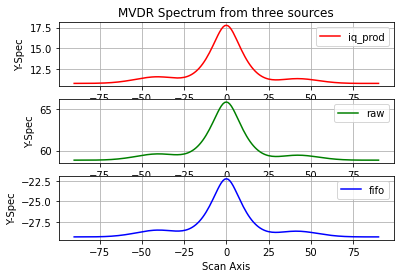

RAW: 0.000 deg, IQ_prod: 0.000 deg, FIFO: 0.000 deg
0.07913 sec raw, 0.06129 sec prod, 0.03903 sec fifo


In [54]:
tic = time.time() 

data = iq_prod[0]

mults = 16
length_data = len(data)
length_ = round(length_data / mults)
raw = np.zeros((mults, length_))

for i in range(mults):
    raw[i] = data[i::mults]

raw_s = raw
rawc = raw.astype(np.cdouble)

zer = np.zeros((1, rawc.shape[1]))
rawc = np.insert(rawc, [1, 8, 13, 16], [zer], axis=0)

rawData_prod = np.zeros(((mults + 4)//2, rawc.shape[1]), dtype=np.cdouble)
idd = 0
for n in range(0, mults + 4, 2):
    rawData_prod[idd, :] = np.conjugate(rawc[n, :] - 1j * rawc[n+1, :])
    idd += 1
    
offset = 2**14
print(offset)
# rawData_prod = rawData_prod[:, :offset]
   
R[0,0] = np.mean(rawData_prod[0])
R[0,1] = np.mean(rawData_prod[1])
R[0,2] = np.mean(rawData_prod[2])
R[0,3] = np.mean(rawData_prod[3])
R[1,0] = np.conj(R[0,1])
R[1,1] = np.mean(rawData_prod[4])
R[1,2] = np.mean(rawData_prod[5])
R[1,3] = np.mean(rawData_prod[6])
R[2,0] = np.conj(R[0,2])
R[2,1] = np.conj(R[1,2])
R[2,2] = np.mean(rawData_prod[7])
R[2,3] = np.mean(rawData_prod[8])
R[3,0] = np.conj(R[0,3])
R[3,1] = np.conj(R[1,3])
R[3,2] = np.conj(R[2,3])
R[3,3] = np.mean(rawData_prod[9])

# MVDR
Rx = R  # Data covariance matrix
Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
num_elements = 4  # Define the number of elements and set its value
A = np.zeros(num_elements, dtype=np.cdouble)

# Assuming scan_axis is already defined as a numpy array
yspec = np.zeros(len(scan_axis))

# Calculate yspec
for t in range(len(scan_axis)):
    A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
    B = np.conj(np.transpose(A))@Rx_Inv@A
    yspec[t] = 10 * np.log10(np.abs(1 / B))
toc = time.time() 

tic3 = time.time() 

## fifo data
fifo_mat = np.zeros((1,len(o1.adc_fifo)),dtype=np.int32)
o1.fifo_capture(fifo_mat)
fifo_mat = fifo_mat[0,32:64]
fpgaR = np.zeros((4, 4), dtype=np.cdouble)
idx = 0
for i in range(4):
    for j in range(4):
        fpgaR[i,j] = np.conjugate(fifo_mat[idx] - 1j * fifo_mat[idx+1])
        idx += 2

# MVDR
# R = fpgaR
Rx = fpgaR/10000  # Data covariance matrix
Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
num_elements = 4  # Define the number of elements and set its value
A = np.zeros(num_elements, dtype=np.cdouble)

# Assuming scan_axis is already defined as a numpy array
yspec_fifo = np.zeros(len(scan_axis))

# Calculate yspec
for t in range(len(scan_axis)):
    A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
    B = np.conj(np.transpose(A))@Rx_Inv@A
    yspec_fifo[t] = 10 * np.log10(np.abs(1 / B))
power_fifo = round(np.max(yspec_fifo)) 
toc3 = time.time() 
t_fifo = toc3-tic3
# Plot data
plt.figure(1)
plt.subplot(311)
plt.plot(scan_axis, yspec, color='r', label='iq_prod') 
plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.title('MVDR Spectrum from three sources')
plt.legend()
plt.grid(True)
plt.subplot(312)
plt.plot(scan_axis, yspec_old, color='g', label='raw') 
plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.legend()
plt.grid(True)
plt.subplot(313)
plt.plot(scan_axis, yspec_fifo, color='b', label='fifo') 
plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.legend()
plt.grid(True)
plt.show()
ang_prod = scan_axis[np.argmax(yspec)]
power = round(np.max(yspec))
ang_fifo = scan_axis[np.argmax(yspec_fifo)]

print("RAW: {:.3f} deg, IQ_prod: {:.3f} deg, FIFO: {:.3f} deg".format(ang_raw, ang_prod, ang_fifo))
deg_diff = np.abs(ang_prod - ang_raw)
# print('{:.5f} deg diff'.format(deg_diff))
t_prod = toc-tic
sec_diff = t_prod-t_raw
print('{:.5f} sec raw, {:.5f} sec prod, {:.5f} sec fifo'.format(t_raw, t_prod, t_fifo))

In [6]:
## Diff test

delay = 8

cnt = 0
prod = np.zeros((rawData_prod.shape[0], rawData.shape[1]), dtype=complex)
streams = channels // 2
for i in range(streams):
    for j in range(i, streams):
        prod[cnt] = rawData[i] * np.conj(rawData[j])
        cnt += 1
        
prod_d = prod[:,:(rawData_prod.shape[1] - delay)] / 2
rawData_prod_d = rawData_prod[:,delay:]
diff = np.abs(prod_d - rawData_prod_d)
plt.plot(diff[:,:100])
# plt.legend()
plt.show()
print(diff)


KeyboardInterrupt



In [ ]:
## Save DATA
from scipy.io import savemat
mdic1 = {"data": iq_prod, "label": "data"}
savemat("raw_data.mat", mdic1)
mdic2 = {"data2": AlignedCaptureSamples, "label": "data2"}
savemat("raw_data2.mat", mdic2)

In [ ]:
iqData[0:3][7:16391]

In [ ]:
len(rawData_prod[0])

In [ ]:
from IPython.display import display, clear_output



while True:
    ## Data collect
    AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
    o1.internal_capture(AlignedCaptureSamples)

    iq_prod = np.zeros((1,len(o1.adc_prod)),dtype=np.int32)
    o1.prod_capture(iq_prod)
    
    ## RAW
    ShapedCaptureSamples = np.zeros((channels, N), dtype=np.int16)
    for i in range(channels):
        ShapedCaptureSamples[i] = AlignedCaptureSamples[0][i::channels]

    iqData = np.zeros((4, N), dtype=np.cdouble)
    idx = 0
    for i in range(0, channels, 2):
        iqData[idx] = np.conjugate(ShapedCaptureSamples[i] - 1j * ShapedCaptureSamples[i+1])
        idx = idx + 1

    rawData = iqData
    rawData = rawData[:,7:16391]
    R = rawData@np.conjugate(rawData.T)

    # MVDR
    Rx = R  # Data covariance matrix
    Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
    num_elements = 4  # Define the number of elements and set its value
    A = np.zeros(num_elements, dtype=complex)

    # Assuming scan_axis is already defined as a numpy array
    yspec = np.zeros(len(scan_axis))

    # Calculate yspec
    for t in range(len(scan_axis)):
        A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
        B = np.conj(np.transpose(A))@Rx_Inv@A
        yspec[t] = 10 * np.log10(np.abs(1 / B))

    ang_raw = scan_axis[np.argmax(yspec)]
    power_old = round(np.max(yspec))
    yspec_old = yspec
    ## IQ PROD
    data = iq_prod[0]

    mults = 16
    length_data = len(data)
    length_ = round(length_data / mults)
    raw = np.zeros((mults, length_))

    for i in range(mults):
        raw[i] = data[i::mults]

    raw_s = raw
    rawc = raw.astype(np.cdouble)

    zer = np.zeros((1, rawc.shape[1]))
    rawc = np.insert(rawc, [1, 8, 13, 16], [zer], axis=0)

    rawData_prod = np.zeros(((mults + 4)//2, rawc.shape[1]), dtype=np.cdouble)
    idd = 0
    for n in range(0, mults + 4, 2):
        rawData_prod[idd, :] = np.conjugate(rawc[n, :] - 1j * rawc[n+1, :])
        idd += 1

    offset = 2**14
    # print(offset)
    # rawData_prod = rawData_prod[:, :offset]

    R[0,0] = np.mean(rawData_prod[0]) #0
    R[0,1] = np.mean(rawData_prod[1])
    R[0,2] = np.mean(rawData_prod[2])
    R[0,3] = np.mean(rawData_prod[3])
    R[1,0] = np.conj(R[0,1])          #4
    R[1,1] = np.mean(rawData_prod[4])
    R[1,2] = np.mean(rawData_prod[5])
    R[1,3] = np.mean(rawData_prod[6])
    R[2,0] = np.conj(R[0,2])          #8
    R[2,1] = np.conj(R[1,2])
    R[2,2] = np.mean(rawData_prod[7])
    R[2,3] = np.mean(rawData_prod[8])
    R[3,0] = np.conj(R[0,3])          #12
    R[3,1] = np.conj(R[1,3])
    R[3,2] = np.conj(R[2,3])
    R[3,3] = np.mean(rawData_prod[9]) #15

    # MVDR
    Rx = R  # Data covariance matrix
    Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
    num_elements = 4  # Define the number of elements and set its value
    A = np.zeros(num_elements, dtype=np.cdouble)

    # Assuming scan_axis is already defined as a numpy array
    yspec = np.zeros(len(scan_axis))

    # Calculate yspec
    for t in range(len(scan_axis)):
        A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
        B = np.conj(np.transpose(A))@Rx_Inv@A
        yspec[t] = 10 * np.log10(np.abs(1 / B))
    power = round(np.max(yspec))
    koef = power_old-power
    # Plot data
    fig = plt.figure()
    plt.subplot(211)
    plt.plot(scan_axis, yspec+koef, color='r', label='iq_prod')
    plt.plot(scan_axis, yspec_old, color='g', label='raw') 
    plt.xlabel('Scan Axis, degree')
    plt.ylabel('Y-Spec, dB')
    plt.title('MVDR DOA Spectrum from two sources (after optimizations)')
    plt.legend()
    plt.grid(True)
    # plt.subplot(212)
    # plt.plot(scan_axis, yspec_old, color='g', label='raw') 
    # plt.xlabel('Scan Axis')
    # plt.ylabel('Y-Spec')
    # plt.legend()
    # plt.grid(True)
    plt.show()
    display(fig)
    
    clear_output(wait = True)
    # plt.pause(2)
    ang_prod = scan_axis[np.argmax(yspec)]
    
    print("IQ_prod: {:.3f}, RAW: {:.3f}".format(ang_prod, ang_raw))
    deg_diff = np.abs(ang_prod - ang_raw)
    print('{:.5f} deg diff'.format(deg_diff))
    clear_output(wait = True)

In [ ]:
o1.ip_dict

In [ ]:
import pynq
from pynq import Overlay, MMIO

# dma_read reads from DDR and sends to Stream
# dma_read_addr = ol.ip_dict["SEG_axi_dma_from_ps_to_pl_Reg"][0]
# dma_read = DMA(dma_read_addr, 0)  # 'DMA_TO_DEV'

dma_write_addr = o1.ip_dict["fifo_mat/axi_dma_0"]
# dma_write = DMA(dma_write_addr, 1) # 'DMA_FROM_DEV'


# dma_read_s = MMIO(dma_read_addr, 128)
dma_write_s = MMIO(dma_write_addr, 128)

def print_dma_status():

    print("Read from Memory, Write to FIFO")

    print("MM 2 Stream        Ctrl   : " + format(dma_read_s.read(0x0), '02x'))
    print("Binary                    : " + format(dma_read_s.read(0x0), '0b'))
    print("MM 2 Stream        Status : " + format(dma_read_s.read(0x4), '02x'))
    print("Binary                    : " + format(dma_read_s.read(0x4), '0b'))
    
    print("\nRead from FIFO, Write to Memory")
    
    print("Stream to MM       Ctrl   : " + format(dma_write_s.read(0x30), '02x'))
    print("Binary                    : " + format(dma_write_s.read(0x30), '0b'))
    print("Stream to MM       Status : " + format(dma_write_s.read(0x34), '02x'))
    print("Binary                    : " + format(dma_write_s.read(0x34), '0b'))

def dma_reset_irq():
    control = dma_read_s.read(0x4)
    control = control | 0x1000
    dma_read_s.write(0x4, control)
    
    control = dma_write_s.read(0x34)
    control = control | 0x1000
    dma_write_s.write(0x34, control)
    
print_dma_status()

In [ ]:
o1.ip_dict["fifo_mat/axi_dma_0"]

In [ ]:
o1?

In [ ]:
o1.fifo_mat.axi_dma_0.recvchannel?

In [ ]:
fifo_mat = o1.fifo_mat.axi_dma_0

dma_send = o1.fifo_mat.axi_dma_0.sendchannel
dma_recv = o1.fifo_mat.axi_dma_0.recvchannel

In [ ]:
fifo_mat.set_up_tx_channel()
fifo_mat.set_up_rx_channel()

In [ ]:
from pynq import allocate
import numpy as np

# data_size = 16
data_size = fifo_mat.buffer_max_size//32

# input_buffer = allocate(shape=(data_size,), dtype=np.int32)
output_buffer = allocate(shape=(data_size,), dtype=np.int32)
# dma_recv.stop()
dma_recv.start()

dma_recv.transfer(output_buffer)
max(output_buffer)

In [ ]:
output_buffer


In [ ]:
dma_recv.start()

In [ ]:
dma_recv.idle

In [ ]:
for i in range(10):
    print('0x' + format(output_buffer[i], '02x'))

In [ ]:
dma_recv.error?


In [ ]:
dma_recv.error


In [ ]:
dma_recv.running


In [ ]:
print("Output buffer address  :", hex(output_buffer.physical_address))
print("---")
print("DMA Source address     :", hex(fifo_mat.register_map.MM2S_SA.Source_Address))
print("DMA Destination address:", hex(fifo_mat.register_map.S2MM_DA.Destination_Address))

In [ ]:
del input_buffer, output_buffer


In [ ]:
fifo_mat.__init__(tx_rx=0)

In [56]:
test = o1.control.gpio_control.axi_gpio_win_len.channel1[0:4]

In [ ]:
test.on()

In [ ]:
o1.control.gpio_control.axi_gpio_win_len.channel1[0:31].off()

In [ ]:
o1.control.gpio_control.axi_gpio_win_len.channel1[0].off()
o1.control.gpio_control.axi_gpio_win_len.channel1[2].on()

o1.control.gpio_control.axi_gpio_win_len.channel1[3].on()

o1.control.gpio_control.axi_gpio_win_len.channel1[1].on()

In [36]:
o1.control.gpio_control.axi_gpio_win_len.channel1[0:4].on()

IQ_prod: -0.200, RAW: -0.200, FIFO: -0.000
0.00000 deg diff


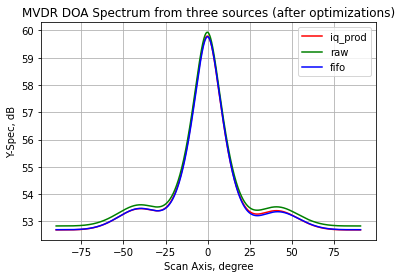

In [14]:
    ## Data collect
    AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
    o1.internal_capture(AlignedCaptureSamples)

    iq_prod = np.zeros((1,len(o1.adc_prod)),dtype=np.int32)
    o1.prod_capture(iq_prod)
    
    ## RAW
    ShapedCaptureSamples = np.zeros((channels, N), dtype=np.int16)
    for i in range(channels):
        ShapedCaptureSamples[i] = AlignedCaptureSamples[0][i::channels]

    iqData = np.zeros((4, N), dtype=np.cdouble)
    idx = 0
    for i in range(0, channels, 2):
        iqData[idx] = np.conjugate(ShapedCaptureSamples[i] - 1j * ShapedCaptureSamples[i+1])
        idx = idx + 1

    rawData = iqData
    rawData = rawData[:,7:16391]
    R = rawData@np.conjugate(rawData.T)

    # MVDR
    Rx = R  # Data covariance matrix
    Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
    num_elements = 4  # Define the number of elements and set its value
    A = np.zeros(num_elements, dtype=complex)

    # Assuming scan_axis is already defined as a numpy array
    yspec = np.zeros(len(scan_axis))

    # Calculate yspec
    for t in range(len(scan_axis)):
        A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
        B = np.conj(np.transpose(A))@Rx_Inv@A
        yspec[t] = 10 * np.log10(np.abs(1 / B))

    ang_raw = scan_axis[np.argmax(yspec)]
    power_old = round(np.max(yspec))
    yspec_old = yspec
    ## IQ PROD
    data = iq_prod[0]

    mults = 16
    length_data = len(data)
    length_ = round(length_data / mults)
    raw = np.zeros((mults, length_))

    for i in range(mults):
        raw[i] = data[i::mults]

    raw_s = raw
    rawc = raw.astype(np.cdouble)

    zer = np.zeros((1, rawc.shape[1]))
    rawc = np.insert(rawc, [1, 8, 13, 16], [zer], axis=0)

    rawData_prod = np.zeros(((mults + 4)//2, rawc.shape[1]), dtype=np.cdouble)
    idd = 0
    for n in range(0, mults + 4, 2):
        rawData_prod[idd, :] = np.conjugate(rawc[n, :] - 1j * rawc[n+1, :])
        idd += 1

    offset = 2**14
    # print(offset)
    # rawData_prod = rawData_prod[:, :offset]

    R[0,0] = np.mean(rawData_prod[0]) #0
    R[0,1] = np.mean(rawData_prod[1])
    R[0,2] = np.mean(rawData_prod[2])
    R[0,3] = np.mean(rawData_prod[3])
    R[1,0] = np.conj(R[0,1])          #4
    R[1,1] = np.mean(rawData_prod[4])
    R[1,2] = np.mean(rawData_prod[5])
    R[1,3] = np.mean(rawData_prod[6])
    R[2,0] = np.conj(R[0,2])          #8
    R[2,1] = np.conj(R[1,2])
    R[2,2] = np.mean(rawData_prod[7])
    R[2,3] = np.mean(rawData_prod[8])
    R[3,0] = np.conj(R[0,3])          #12
    R[3,1] = np.conj(R[1,3])
    R[3,2] = np.conj(R[2,3])
    R[3,3] = np.mean(rawData_prod[9]) #15

    # MVDR
    Rx = R  # Data covariance matrix
    Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
    num_elements = 4  # Define the number of elements and set its value
    A = np.zeros(num_elements, dtype=np.cdouble)

    # Assuming scan_axis is already defined as a numpy array
    yspec = np.zeros(len(scan_axis))

    # Calculate yspec
    for t in range(len(scan_axis)):
        A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
        B = np.conj(np.transpose(A))@Rx_Inv@A
        yspec[t] = 10 * np.log10(np.abs(1 / B))
    power = round(np.max(yspec))
    koef = power_old-power
    
    ## fifo data
    fifo_mat = np.zeros((1,len(o1.adc_fifo)),dtype=np.int32)
    o1.fifo_capture(fifo_mat)
    fifo_mat = fifo_mat[0,32:64]
    fpgaR = np.zeros((4, 4), dtype=np.cdouble)
    idx = 0
    for i in range(4):
        for j in range(4):
            fpgaR[i,j] = np.conjugate(fifo_mat[idx] - 1j * fifo_mat[idx+1])
            idx += 2
            
    # MVDR
    # R = fpgaR
    Rx = fpgaR/10000  # Data covariance matrix
    Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
    num_elements = 4  # Define the number of elements and set its value
    A = np.zeros(num_elements, dtype=np.cdouble)

    # Assuming scan_axis is already defined as a numpy array
    yspec_fifo = np.zeros(len(scan_axis))

    # Calculate yspec
    for t in range(len(scan_axis)):
        A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
        B = np.conj(np.transpose(A))@Rx_Inv@A
        yspec_fifo[t] = 10 * np.log10(np.abs(1 / B))
    power_fifo = round(np.max(yspec_fifo))       
    koef2 = power_fifo-power_old

    # Plot data
    fig = plt.figure()
    # plt.subplot(211)
    plt.plot(scan_axis, yspec+koef, color='r', label='iq_prod')
    plt.plot(scan_axis, yspec_old, color='g', label='raw')
    # plt.plot(scan_axis, yspec_old-0.1, color='b', label='fifo') 
    plt.plot(scan_axis, yspec_fifo-koef2, color='b', label='fifo') 
    plt.xlabel('Scan Axis, degree')
    plt.ylabel('Y-Spec, dB')
    plt.title('MVDR DOA Spectrum from three sources (after optimizations)')
    plt.legend()
    plt.grid(True)
    # plt.subplot(212)
    # plt.plot(scan_axis, yspec_old, color='g', label='raw') 
    # plt.xlabel('Scan Axis')
    # plt.ylabel('Y-Spec')
    # plt.legend()
    # plt.grid(True)
    ang_prod = scan_axis[np.argmax(yspec)]
    ang_fifo = scan_axis[np.argmax(yspec_fifo)]
    print("IQ_prod: {:.3f}, RAW: {:.3f}, FIFO: {:.3f}".format(ang_prod, ang_raw, ang_fifo))
    # print("IQ_prod: {:.3f}, RAW: {:.3f}, FIFO: {:.3f}".format(ang_prod, ang_raw, ang_raw))
    deg_diff = np.abs(ang_prod - ang_raw)
    print('{:.5f} deg diff'.format(deg_diff))
    plt.show()
    # display(fig)
    
    # clear_output(wait = True)
    # plt.pause(2)
    
    # print("IQ_prod: {:.3f}, RAW: {:.3f}".format(ang_prod, ang_raw))
    # deg_diff = np.abs(ang_prod - ang_raw)
    # print('{:.5f} deg diff'.format(deg_diff))

In [ ]:
AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
o1.internal_capture(AlignedCaptureSamples)
fifo_mat = np.zeros((1,len(o1.adc_fifo)),dtype=np.int32)
o1.fifo_capture(fifo_mat)

In [ ]:
o1.trigger_capture()
fifo_mat = np.zeros((1,len(o1.adc_fifo)),dtype=np.int32)
o1.fifo_capture(fifo_mat)
print(fifo_mat[:,0:128])
fifo_mat = fifo_mat[0,32:64]


In [ ]:
(fifo_mat)

In [ ]:
np.set_printoptions(threshold=np.inf)


In [ ]:
print(R)
print('------')
print((fpgaR/10000))

In [ ]:
fpgaR = np.zeros((4, 4), dtype=np.cdouble)
idx = 0
for i in range(4):
    for j in range(4):
        fpgaR[i,j] = np.conjugate(fifo_mat[idx] - 1j * fifo_mat[idx+1])
        idx += 2
print((fpgaR))        

In [55]:
bin(10)

'0b1010'

In [58]:
test.write(14)

In [60]:
np.log2(16384)

14.0